In [19]:
import cv2
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from Thresholding import otsu
from Boundaries import boundaries_detection
from Boundaries import freeman_chain_code
from Borders import border_detection
from Boundaries import fourier_descriptors
from Boundaries import extreme_points
class Image:
    def __init__(self,data,label,rotated=False,resized=False):
        self.data = data
        self.borderImage = None
        self.label = label
        self.boundary = None
        self.boundaryImage = None
        self.extremePoints = None
        self.rotated = rotated
        self.resized = resized

    def __str__(self) -> str:
        return f"{self.data}"

    def getBoundaries(self)->None:
        binaryImage = otsu.otsu_image(self.data)
        self.borderImage = border_detection.canny_bordering(binaryImage)
        self.boundaryImage,self.boundary = boundaries_detection.moore_boundary_detection(self.borderImage)

    def getFreemanChain(self):
        if(self.boundary is None):
            self.getBoundaries()
        freemanChainCode = freeman_chain_code.calculate_chain_code(self.boundaryImage)
        self.freemanChainCode = freeman_chain_code.normalize_chain(freemanChainCode)

    def getArea(self):
        rows,columns = self.data.shape
        area = 0
        for r in range(rows):
            for c in range(columns):
                if(self.data[r][c] == 255):
                    area += 1
        self.area = area

    def getPerimeter(self):
        if(self.freemanChainCode is None):
            self.getFreemanChain()
        perimeter = 0
        for value in self.freemanChainCode:
            if(value%2 == 0):
                perimeter += 1
            else:
                perimeter += math.sqrt(2)
        self.perimeter = perimeter
        
    def getCompactness(self):
        if(self.perimeter is None):
            self.getPerimeter()
        if(self.area is None):
            self.getArea()
        self.compactness = self.perimeter**2 / self.area

    def getRectangularity(self):
        rows,columns = self.data.shape
        points = [math.inf,-1,math.inf,-1] # heighleast,heighmost,leftmost,rightmost
        for r in range(rows):
            for c in range(columns):
                if(self.data[r][c] == 255):
                    if(r < points[0]):
                        points[0] = r
                    if(r > points[1]):
                        points[1] = r
                    if(c < points[2]):
                        points[2] = c
                    if(c > points[3]):
                        points[3] = c
        areaR = (points[1]-points[0]) * (points[3]-points[2])
        self.rectangularity = self.area/areaR

    def getFourierDescriptors(self):
        if self.boundary is None:
            self.getBoundaries()
        self.fourierDescriptors = fourier_descriptors.fourier_descriptors(self.boundary.copy())

    def getExtremePoints(self):
        if self.boundary is None:
            self.getBoundaries()
        self.extremePoints = extreme_points.findExtremePoints(self.boundary)
        
    def plotExtremePoints(self):
        if self.extremePoints is None:
            self.getExtremePoints()
        plt.figure()
        plt.imshow(self.data, cmap="gray")
        for point in self.extremePoints:
            y, x = point
            plt.scatter(x, y, c="red")
        plt.show()

    def plotImage(self):
        plt.figure()
        plt.subplot(131)
        plt.imshow(self.data,cmap="gray")
        plt.subplot(132)
        plt.imshow(self.borderImage,cmap="gray")
        plt.subplot(133)
        plt.imshow(self.boundaryImage,cmap="gray")
        plt.show()


## Load data

In [20]:
images = []
imagesRotated = []
imagesResized = []
folder_path = 'images'
init_folders = os.listdir(folder_path)
for folder in init_folders:
    init_folder_path = os.path.join(folder_path, folder)
    cont = 0
    for image_path in os.listdir(init_folder_path):
        if(cont == 10):
            break
        image_folder = os.path.join(init_folder_path,image_path)
        image = cv2.imread(image_folder,cv2.IMREAD_GRAYSCALE)
        imageR = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        imagesRZD = cv2.resize(image,(37,37),interpolation=cv2.INTER_NEAREST)
        images.append(Image(image,folder))
        imagesRotated.append(Image(imageR,folder,rotated=True))
        imagesResized.append(Image(imagesRZD,folder,resized=True))
        cont += 1

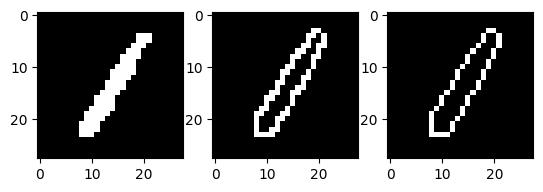

0.3117408906882591

In [21]:
image = images[12]
image.getFreemanChain()
image.plotImage()
image.getArea()
image.getPerimeter()
image.getCompactness()
image.getRectangularity()
image.rectangularity

Comparacion entre descriptores de Fourier
[ 641.        +6.52000000e+02j -128.19969269-1.32580168e+01j
  -29.52429698+2.33427564e+01j    6.16799178+1.61061506e+01j
    1.73205081-2.00000000e+00j   -2.90992063-9.15200041e+00j
   -2.41421356+4.82842712e+00j    0.8840488 -1.08423271e+00j
    2.        -2.67949192e-01j   -4.68337016-3.82362695e+00j]
[644.        +6.41000000e+02j  93.63668518+8.85613200e+01j
 -22.47673103+3.01888216e+01j -17.24053114-4.65075633e-01j
  -2.59807621-5.00000000e-01j  -1.69045009-9.45352464e+00j
  -1.70710678-5.12132034e+00j  -1.19034847-7.34964869e-01j
   1.8660254 +7.67949192e-01j   5.79010852+1.74032251e+00j]
[ 1.15900000e+03+1.19100000e+03j -2.35999756e+02-2.98716541e+01j
 -6.06122154e+01+3.71636045e+01j  6.95551380e+00+2.78883076e+01j
  3.23044250e+00-3.10345996e+00j -3.87235929e+00-1.15684785e+01j
 -3.93343464e+00+7.05749785e+00j  1.72807540e+00+1.01164831e+00j
  4.53553391e+00-7.07106781e-01j -2.90337044e+00-6.61609302e+00j
 -2.78012004e+00+1.99608717e-02

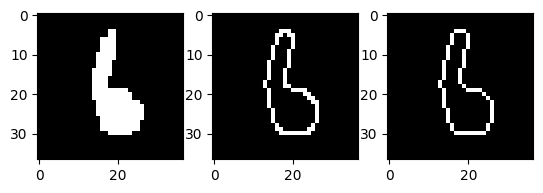

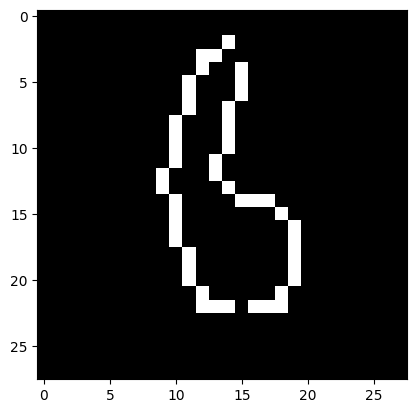

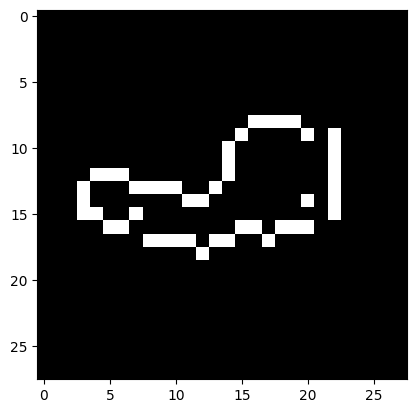

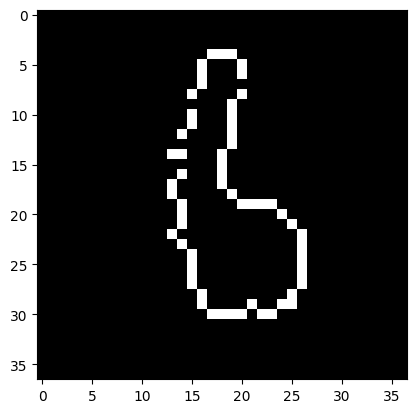

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [22]:
# Se obtienen los descriptores de Fourier
imagen = images[65]
imagen.getFourierDescriptors()

imagenRotada = imagesRotated[65]
imagenRotada.getFourierDescriptors()

imagenResized = imagesResized[65]
imagenResized.getFourierDescriptors()

print("Comparacion entre descriptores de Fourier")

print(imagen.fourierDescriptors[:10])
print(imagenRotada.fourierDescriptors[:10])
print(imagenResized.fourierDescriptors)

# Se grafican los descriptores de Fourier

# Se calculan los descriptores normalizados

descriptor_normal_InvarianteRot = fourier_descriptors.calculate_rotation_invariance(imagen.fourierDescriptors.copy())
descriptor_normal_InvarianteScale = fourier_descriptors.calculate_scale_invariance(imagen.fourierDescriptors.copy())
descriptor_rotado = fourier_descriptors.calculate_rotation_invariance(imagenRotada.fourierDescriptors.copy())
descriptor_resized = fourier_descriptors.calculate_scale_invariance(imagenResized.fourierDescriptors.copy())

print("Comparacion entre invarianza a rotación")
print("Original vs Rotado")
print(descriptor_normal_InvarianteRot[:10])
print(descriptor_rotado[:10])
print("Original vs Resized")
print(descriptor_normal_InvarianteScale[:10])
print(descriptor_resized[:10])

imagenResized.plotImage()

fourier_descriptors.plot_IDFT(imagen.fourierDescriptors, 1)
fourier_descriptors.plot_IDFT(imagenRotada.fourierDescriptors, 1)
fourier_descriptors.plot_IDFT(imagenResized.fourierDescriptors, 1, width=37, height=37)


<h2>Extreme Points</h2>

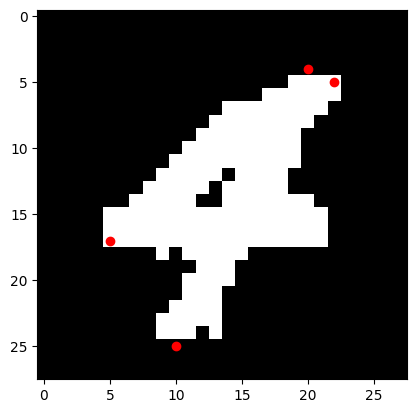

In [23]:
image = images[40]

image.plotExtremePoints()

[[9.20000000e+01 1.36651804e+02 2.02975168e+02 6.13333333e-01
  6.00000000e+00 6.00000000e+00 3.10000000e+01 1.80000000e+01
  8.00000000e+00 2.20000000e+01 3.00000000e+01 1.50000000e+01
  4.15018171e+01 3.95615992e+04]
 [1.49000000e+02 1.59279221e+02 1.70267585e+02 4.09340659e-01
  7.00000000e+00 7.00000000e+00 3.30000000e+01 2.40000000e+01
  2.90000000e+01 2.50000000e+01 2.10000000e+01 1.10000000e+01
  4.62076400e+01 5.06908540e+04]
 [2.43000000e+02 2.89102597e+02 3.43951900e+02 4.06354515e-01
  3.00000000e+00 3.00000000e+00 3.10000000e+01 1.60000000e+01
  2.30000000e+01 2.90000000e+01 2.70000000e+01 6.00000000e+00
  5.82251616e+01 9.04558306e+04]
 [2.33000000e+02 2.06735065e+02 1.83430845e+02 5.27149321e-01
  4.00000000e+00 4.00000000e+00 3.00000000e+01 2.00000000e+01
  1.70000000e+01 2.70000000e+01 2.50000000e+01 9.00000000e+00
  4.96631866e+01 6.32125679e+04]
 [1.49000000e+02 1.59279221e+02 1.70267585e+02 4.09340659e-01
  7.00000000e+00 7.00000000e+00 3.30000000e+01 2.40000000e+01


C:\Users\mexbo\AppData\Local\Temp\ipykernel_7996\684753288.py:66: RuntimeWarning: divide by zero encountered in divide
  clusterUp[i] = clusterUp[i] / aux[i]
C:\Users\mexbo\AppData\Local\Temp\ipykernel_7996\684753288.py:66: RuntimeWarning: invalid value encountered in divide
  clusterUp[i] = clusterUp[i] / aux[i]


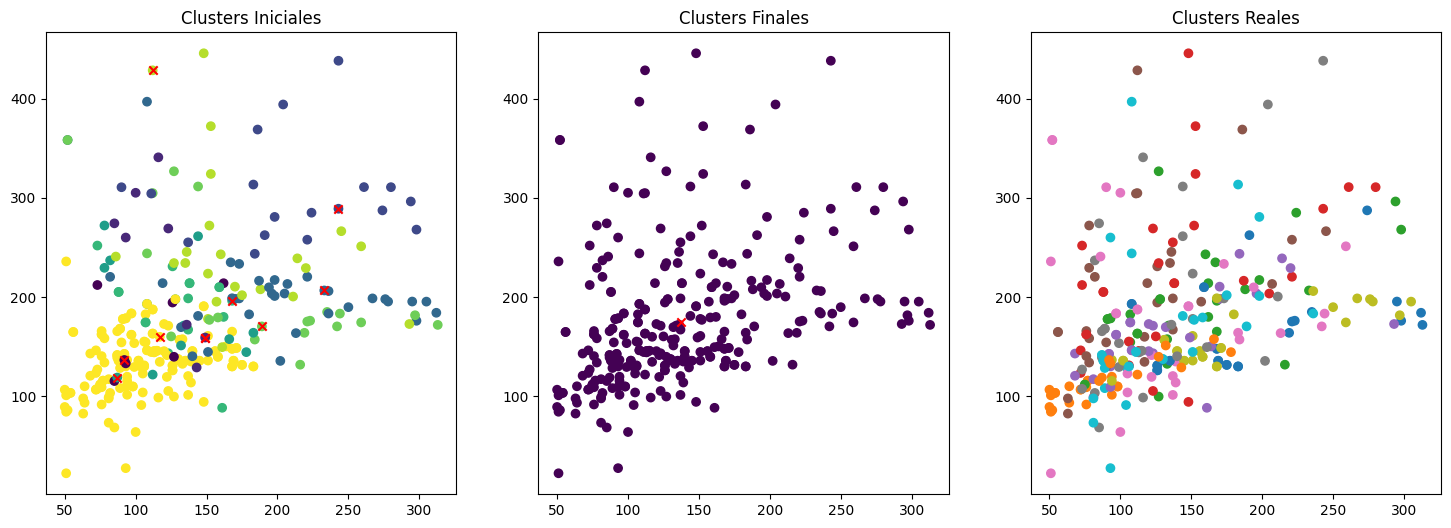

In [26]:
listImages = images + imagesRotated + imagesResized 

b_feature = np.zeros((len(listImages), 14))
labels = [int(imagen.label) for imagen in listImages]

for i in range(len(listImages)):
    listImages[i].getFreemanChain()
    listImages[i].getArea()
    listImages[i].getPerimeter()
    listImages[i].getCompactness()
    listImages[i].getRectangularity()
    listImages[i].getFourierDescriptors()
    listImages[i].getExtremePoints()
    b_feature[i][0] = listImages[i].area
    b_feature[i][1] = listImages[i].perimeter
    b_feature[i][2] = listImages[i].compactness
    b_feature[i][3] = listImages[i].rectangularity
    eP = listImages[i].extremePoints
    b_feature[i][4] = eP[0][0]
    b_feature[i][5] = eP[0][0]
    b_feature[i][6] = eP[1][0]
    b_feature[i][7] = eP[1][1]
    b_feature[i][8] = eP[2][0]
    b_feature[i][9] = eP[2][1]
    b_feature[i][10] = eP[3][0]
    b_feature[i][11] = eP[3][1]
    b_feature[i][12] = np.mean(np.abs(listImages[i].fourierDescriptors))
    b_feature[i][13] = np.var(np.abs(listImages[i].fourierDescriptors))



import random

k = 10

firstcopy = b_feature
clusters = np.array([firstcopy[random.randint(0, len(firstcopy) - 1)] for _ in range(k)])
print(clusters)


def distancia_euclidiana(p1, p2):
    n = len(p2)
    m = len(p1)
    distanciaP = np.zeros((n, m))
    
    for i in range(n):
        for j in range(m):
            distanciaP[i][j] = (np.sum((p1[j] - p2[i]) **2)) ** 0.5 
    return distanciaP

def valores_minimos(d):
    d = np.argmin(d, axis=0)
    return d

def new_clusters(datos, dis_min):
    n = np.max(dis_min) + 1
    m = len(datos[0])
    clusterUp = np.zeros((n, m))
    aux = [0] * n
    for i in range(len(dis_min)):
        grupo = dis_min[i]
        clusterUp[grupo] += datos[i]
        aux[grupo] += 1

    for i in range(n):
        clusterUp[i] = clusterUp[i] / aux[i]
    return clusterUp


firstC = clusters.copy()
firstD = valores_minimos(distancia_euclidiana(firstcopy, firstC))

iteraciones = 0
while True:
    distancias_clusters = distancia_euclidiana(firstcopy, clusters)
    distancia_min = valores_minimos(distancias_clusters)
    
    nuevosCluster = new_clusters(firstcopy, distancia_min)
    
    if np.array_equal(clusters, nuevosCluster):
        break
    
    clusters = nuevosCluster.copy()
    iteraciones += 1
    

print(f'\nIteraciones realizadas: {iteraciones}')
colors = plt.cm.tab10(np.linspace(0, 1, 10))

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(firstcopy[:, 0], firstcopy[:, 1], c=firstD, cmap='viridis')
plt.scatter(np.array(firstC)[:, 0], np.array(firstC)[:, 1], c='red', marker='x')
plt.title('Clusters Iniciales')

plt.subplot(1, 3, 2)
plt.scatter(firstcopy[:, 0], firstcopy[:, 1], c=distancia_min, cmap='viridis')
plt.scatter(np.array(nuevosCluster)[:, 0], np.array(nuevosCluster)[:, 1], c='red', marker='x')
plt.title('Clusters Finales')


plt.subplot(1, 3, 3)
plt.scatter(firstcopy[:, 0], firstcopy[:, 1], c=labels,cmap=plt.cm.tab10)
plt.title('Clusters Reales')
plt.show()